# Character Segmentation Module

Get the WPOD-NET outputs from 'lp_out/' directory and process these images before sending it for OCR

In [10]:
import os
import json
from os.path import splitext,basename
import glob

import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from utils import detect_lp

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

In [2]:
!pwd

/home/jwillow/Documents/Deep Learning/project-lpdr


## Retreive detected LP collection

In [3]:
src_path = 'lp_out/'
demo_lp = '00fb62be50bc2353_instance_2.jpg'

im = cv2.imread(src_path + demo_lp)

# Convert to Grayscale - better accuracy by ignoring color variates
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Filter Gaussian Noise - 2d convolution with a kernel
# Adjust kernel size to see different effects
im_blur1 = cv2.GaussianBlur(im_gray, (1,1), 0)
im_blur5 = cv2.GaussianBlur(im_gray, (5,5), 0)
im_blur7 = cv2.GaussianBlur(im_gray, (7,7), 0)

# plt expects a 3 channel image but grayscale is only one channel, 
# specify the following attributes to show grayscale 
# plt.imshow(im_blur7, cmap='gray', vmin = 0, vmax = 255)

# Convert Grayscale+GB to Binary - cv2.threshold(src=grayscale_im, threshold, color. type)
_, im_binary1 = cv2.threshold(im_blur1, 120, 255, cv2.THRESH_BINARY_INV)
_, im_binary5 = cv2.threshold(im_blur5, 120, 255, cv2.THRESH_BINARY_INV)
_, im_binary7 = cv2.threshold(im_blur7, 120, 255, cv2.THRESH_BINARY_INV)

# Color dilation - enhance white colored regions (morphological Operation)
# 1. Construct a filter with cv2.getStructuringElement(type, kernal_sz)
dilation_filter3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# 2. Apply Morphological operation on image with filter (iteration = num_operations) 
im_dilated7 = cv2.dilate(im_binary7, dilation_filter3,iterations = 1)




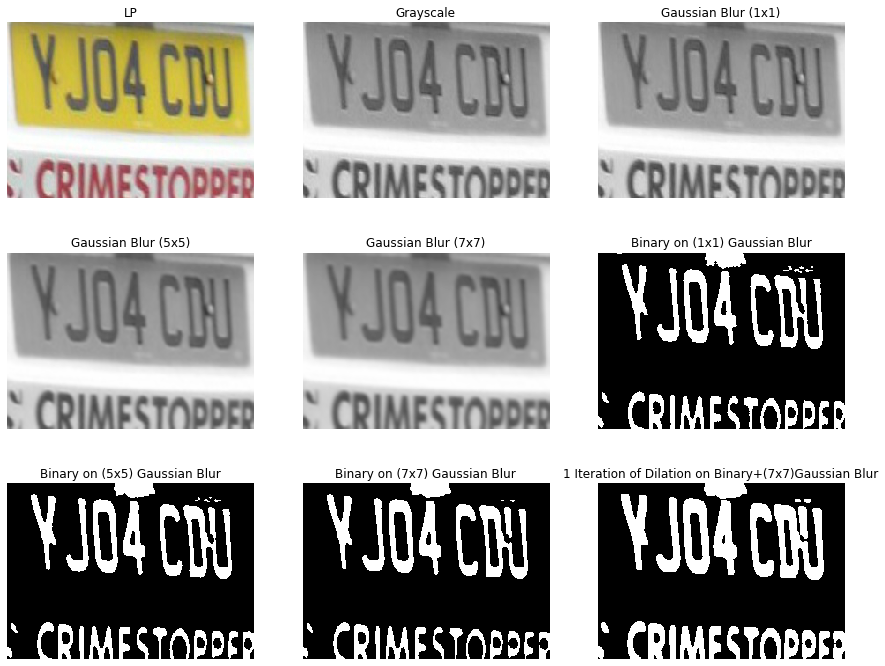

In [4]:
# Plot the various processed image
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(331)
ax1.set_title('LP')
ax1.axis('off')
ax1 = plt.imshow(im)

ax2 = fig.add_subplot(332)
ax2.set_title('Grayscale')
ax2.axis('off')
ax2 = plt.imshow(im_gray, cmap='gray', vmin = 0, vmax = 255)

ax3 = fig.add_subplot(333)
ax3.set_title('Gaussian Blur (1x1)')
ax3.axis('off')
ax3 = plt.imshow(im_blur1, cmap='gray', vmin = 0, vmax = 255)

ax4 = fig.add_subplot(334)
ax4.set_title('Gaussian Blur (5x5)')
ax4.axis('off')
ax4 = plt.imshow(im_blur5, cmap='gray', vmin = 0, vmax = 255)

ax5 = fig.add_subplot(335)
ax5.set_title('Gaussian Blur (7x7)')
ax5.axis('off')
ax5 = plt.imshow(im_blur7, cmap='gray', vmin = 0, vmax = 255)

ax6 = fig.add_subplot(336)
ax6.set_title('Binary on (1x1) Gaussian Blur')
ax6.axis('off')
ax6 = plt.imshow(im_binary1, cmap='gray', vmin = 0, vmax = 255)

ax7 = fig.add_subplot(337)
ax7.set_title('Binary on (5x5) Gaussian Blur')
ax7.axis('off')
ax7 = plt.imshow(im_binary5, cmap='gray', vmin = 0, vmax = 255)

ax8 = fig.add_subplot(338)
ax8.set_title('Binary on (7x7) Gaussian Blur')
ax8.axis('off')
ax8 = plt.imshow(im_binary7, cmap='gray', vmin = 0, vmax = 255)

ax9 = fig.add_subplot(339)
ax9.set_title('1 Iteration of Dilation on Binary+(7x7)Gaussian Blur')
ax9.axis('off')
ax9 = plt.imshow(im_dilated7, cmap='gray', vmin = 0, vmax = 255)


plt.savefig('demo-graphs')


## Get the outline of each character

In [5]:
# cv2.findContour(src, contour_retrieval_mode, contour_approx_method)
# returns a list of contours
contour, _ = cv2.findContours(im_dilated7, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# im.shape = 200, 280 (H,W)
cv2.boundingRect(contour[2])
contour[0]


array([[[  0, 185]],

       [[  0, 197]],

       [[  2, 199]],

       [[  5, 199]],

       [[  5, 198]],

       [[  6, 197]],

       [[  6, 190]],

       [[  4, 188]],

       [[  4, 187]],

       [[  3, 186]],

       [[  2, 186]],

       [[  1, 185]]], dtype=int32)

Detect 8 letters...


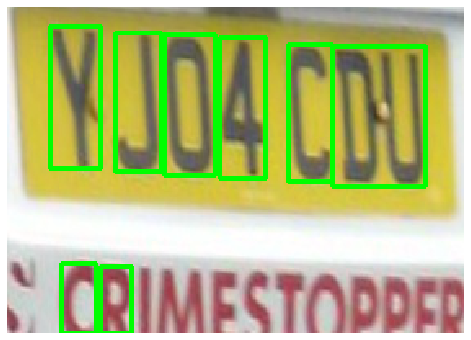

In [6]:
def sort_contours(cnts,reverse = False):
    '''
    Input (list of contours (list)) and grab each contour bbox 
    '''
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = im.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

'''
Loops through the contours list (now with bbox) and map bbox to image
Script saves binary image for each character in crop_characters
NOTE: need to modify bbox_height, width ratio and bbox_height & im_height ratio 
'''
for c in sort_contours(contour):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    # print(ratio)

    # Select contours that satisfy both conditions     
    if 1<=ratio<=5 and h/im.shape[0]>=0.2: 
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Seperate number and give prediction
            curr_num = im_dilated7[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

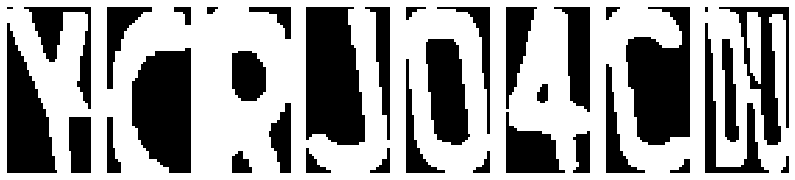

In [7]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)


In [8]:
!pwd

/home/jwillow/Documents/Deep Learning/project-lpdr


In [11]:
# Read json and load architecture
with open('character_recognition/mobile_base.json','r') as f:
    model_json = json.load(f)

model = model_from_json(model_json)
model.load_weights('character_recognition/License_character_recognition.h5')

class_labels = 'character_recognition/license_character_classes.npy'
labels = LabelEncoder()
labels.classes_ = np.load(class_labels)


In [20]:
def predict_char(image):
    # Preprocess image and Predict
    im = cv2.resize(image, (128, 128))
    im = np.stack((im,)*3, axis=-1)
    im = im[np.newaxis,:]
    
    result = labels.inverse_transform([np.argmax(model.predict(im))])
    
    return result

In [ ]:
# model.predict(crop_characters[0])
im = cv2.resize(crop_characters[4], (150, 150))
print(im.shape)
im = np.stack((im,)*3, axis=-1)
print(im.shape)
im = im[np.newaxis,:]
print(im.shape)


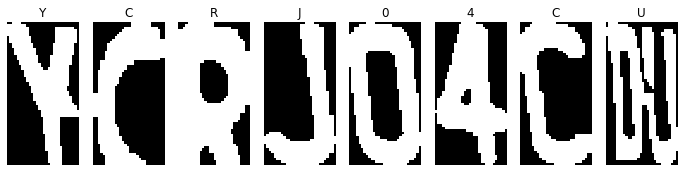

In [21]:
fig = plt.figure(figsize=(12,10))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_char(character))
    plt.title('{}'.format(title.strip("'[]"),fontsize=26))
    plt.axis(False)
    plt.imshow(character,cmap='gray')
    
